In [1]:
%matplotlib inline

//anaconda/lib/python2.7/site-packages/ipykernel/pylab/config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
//anaconda/lib/python2.7/site-packages/ipykernel/pylab/config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
//anaconda/lib/python2.7/site-packages/ipykernel/pylab/config.py:85: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  use `figure_formats` instead)""")
//anaconda/lib/python2.7/site-packages/ipykernel/pylab/config.py:95: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag()

# Motivation
__how will implementation of a Tesla battery storage (and car charging) effect power load?__

In [115]:
# make the code as Python 3 compatible as possible
from __future__ import print_function, division
import pypsa
import plotly as py
import numpy as np
import matplotlib.pylab as plt
import cufflinks as cf
import networkx as nx
import pandas as pd
from numpy.random import rand
import plotly.graph_objs as go
import time
cf.go_offline()

In [143]:
def interpolate(series, td):
    tmp = pd.Series(np.zeros((len(td))), index = td)
    tmp = tmp.add(series)
    return tmp.interpolate(method='time')

In [296]:
network = pypsa.Network()
layout = go.Layout(
        autosize=True)
# make fake pseudorandom hourly loads
hrs = pd.date_range("00:00", "23:30", freq="60min")
t = pd.date_range("00:00", "23:59", freq="5min")

      #0,1,2,3,4,5,6,7,8,9,10,11,12,1 ,2 ,3 ,4 ,5,6,7,8,9,10,11
base= [3,3,3,3,3,6,7,7,8,8,9 ,9 ,10,10,10,10,10,9,9,7,6,5, 4,3]
sunshine = [0,0,0,0,0,0,0,0,0,1,1,2,2,3,3,2,1,0,0,0,0,0,0,0]
sunshine = [i / max(sunshine) for i in sunshine]

profile = lambda base: base + np.var(base)*rand(len(base))
network.set_snapshots(t)

#add buses
# we will make nice little california houses all made of ticky tacky 
N = 6 # make sure is even
itr = 0 
car_charge = 10 

# randomly select some houses to get a solar panel
N_panels = 15
getPanel = np.random.choice(np.arange(N**2), N_panels)
percentCloudy = .05

# randomly select some of the above to get storage 
N_storage = int(N_panels / 3)
getStorage = np.random.choice(getPanel, N_storage)
# do a random draw to see if its cloudy 
cloudy = (1e-6 if rand()< percentCloudy else 1.)
for i in range(N):
    for j in range(N):
        
        # to make the timeframe of the loads arbitrary, we will 
        # create an iterpolant for the loads and sunshine
        loads = pd.Series(profile(base), hrs)
        solar = pd.Series(profile(sunshine), hrs)
        
        network.add("Bus","Home {}".format(itr), 
                   x = (i - N/2),
                   y = (j-N/2))
        
        # add the loads
        network.add("Load", "{}".format(itr),
                   bus="Home {}".format(itr),
                    p_set = interpolate(loads, t)
                   )
        # add solar panel if chosen
        if itr in getPanel:
            network.add("Generator", "Home Panel {}".format(itr),
                   bus="Home {}".format(itr),
                    p_nom = 15*cloudy,
                    dispatch='variable',
                    p_max_pu = interpolate(solar, t),
                    p_min_pu = pd.Series(np.zeros((len(t))), t)
                       )
        
        if itr in getStorage:
            network.add("StorageUnit", "Storage Cell {}".format(itr),
                       bus="Home {}".format(itr), 
                       p_nom = 5,
                       standing_loss = .01
                       )
        
            
        itr +=1



# add the bus to for the generation plant
network.add("Bus", "Gen Bus 1",
        x = 10,
        y = 10
        )

network.add("Bus", "Gen Bus 2",
        x = 1,
        y = 10
        )

# this will the the big nasty coal plant
network.add("Generator", "Gen1",
    bus="Gen Bus 1",
    p_nom = 400
    ,p_nom_max_pu_fixed = .9
    ,p_nom_min_pu_fixed = .6
    ,marginal_cost = 1.0
    )

# natural gas
network.add("Generator", "Gen2",
    bus="Gen Bus 2",
    control='Slack',
    dispatch='variable',
    p_max_pu = pd.Series(np.ones((len(t))), t),
    p_min_pu = pd.Series(np.zeros((len(t))), t)
    ,p_nom = 250
    ,marginal_cost = 1.2
            
            )

# network.add("Line", "Backup Gen", 
#            b0)
# connect all the houses in a column
itr = 0
for i in range(N):
    for j in range(N):     
        if itr%N != 0 :
            network.add("Line", "Home Line ({i}, {j})".\
                    format(i=i, j=j),
                   bus0="Home {}".format(itr),
                   bus1="Home {}".format(itr-1),
                   x=80,
                   s_nom=300)

        if j == N-1:
            # add connection to generator 
            network.add("Line", "Gen Line 1, {}".\
                    format(i),
                   bus0="Home {}".format(itr),
                   bus1="Gen Bus 1",
                   x=.0001, 
                   s_nom=1000)     

            network.add("Line", "Gen Line 2, {}".\
                format(i),
               bus0="Home {}".format(itr),
               bus1="Gen Bus 2",
               x=.0001, 
               s_nom=1000)  
        itr +=1      

        
itr = N**2 
for i in range(N):
    for j in range(N):
        
        # to make the timeframe of the loads arbitrary, we will 
        # create an iterpolant for the loads and sunshine
        loads = pd.Series(profile(base), hrs)
        solar = pd.Series(profile(sunshine), hrs)
        
        network.add("Bus","Home {}".format(itr), 
                   x = (i - N/2),
                   y = (j-N/2)+20
                    )
        
        # add the loads
        network.add("Load", "{}".format(itr),
                   bus="Home {}".format(itr),
                    p_set = interpolate(loads, t)
                   )
            
        itr +=1



# add a bus at the same location as the first generator bus
network.add("Bus", "Gen Bus 3",
           x = 10,
           y = 10)

# add second generator at the first bus
network.add("Generator", "Gen 3",
           bus="Gen Bus 3", 
           p_nom = 800,
           p_nom_max_pu_fixed = .9,
           p_nom_min_pu_fixed = .6,
           marginal_cost = 1.0
           )

        
# connect all the houses in a column
itr = N**2 
for i in range(N):
    for j in range(N):     
        if itr%N != 0 :
            network.add("Line", "Home Line ({i}, {j})".\
                    format(i=i+ N**2 , j=j +N**2 ),
                   bus0="Home {}".format(itr),
                   bus1="Home {}".format(itr-1),
                   x=80,
                   s_nom=300)

        if j == 0:
            # add connection to generator 
            network.add("Line", "Gen Line 3, {}".\
                    format(i),
                   bus0="Home {}".format(itr),
                   bus1="Gen Bus 3",
                   x=.0001, 
                   s_nom=1000)     

        itr +=1      

        

(<matplotlib.collections.PathCollection at 0x12462a690>,
 <matplotlib.collections.LineCollection at 0x1204a7950>)

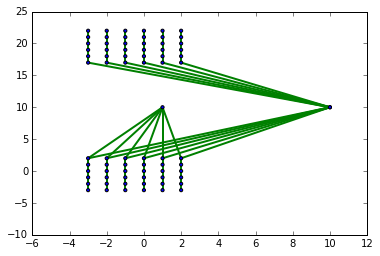

In [295]:
network.plot()


In [297]:
#Do a linear OPF
network.lopf(t)

Slack bus is Gen Bus 2
No slack generator found, using Gen 3 as the slack generator
Slack bus is Gen Bus 3
# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 199042.919587
  Upper bound: 199042.919587
  Number of objectives: 1
  Number of constraints: 91873
  Number of variables: 51553
  Number of nonzeros: 169917
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 3.8964600

In [423]:
interpolate(solar, t).iplot(title='Representative solar availabilty', xTitle='Time')

In [422]:
cf.go_online()
interpolate(loads, t).iplot(title='Representative household load', xTitle='Time')

## Plot the aggregate demand

In [421]:
len(t)

288

In [416]:
network.loads_t.ix['p'].iplot(layout=layout)

In [424]:
aggDemand = network.loads_t.ix['p'].sum(axis=1)
solarDemand = network.loads_t.ix['p',:,:N**2].sum(axis=1)
noSolarDemand = network.loads_t.ix['p',:,N**2:].sum(axis=1)
homeGen = network.generators_t.ix['p',:, :-3].sum(axis=1)
publicGen = network.generators_t.ix['p', :, -3:]
macros =pd.concat([aggDemand, solarDemand, noSolarDemand, homeGen, publicGen], axis=1)
macros.columns = ['Aggregate Demand','Demand (w/solar)', 'Demand (w/out solar)', 
                  'Home Generation', 'Gen 1', 'Gen 2', 'Gen 3']
macros.iplot(title='Power generation and demand', xTitle='Time', yTitle='Power (kWh)')

In [198]:
def lineMaker(network, t_int):
    N = len(network.lines.index)
    trace =[] 
    # find mean for normalization 
    norm = abs(network.lines_t.ix['p0'].iloc[t_int,:]).mean()
    for line in range(N):
        bus0 = network.lines.ix[line, 'bus0']
        bus1 = network.lines.ix[line, 'bus1']
        
        xLoc = np.asarray([network.buses.ix[bus0, 'x'], \
             network.buses.ix[bus1, 'x']])
        
        yLoc = np.asarray([network.buses.ix[bus0, 'y'], \
             network.buses.ix[bus1, 'y']])
        
        
        tmp = go.Scatter(
                x = xLoc,
                y = yLoc,
                line = dict(
                    color='black',
                    width = abs(network.lines_t.ix['p0'].iloc[t_int, line])/norm
                            )
                        )
        print
        trace.append(tmp)
    return trace
    

In [206]:
netPanel = pd.Panel(np.zeros((len(t), len(network.buses), 6)))
netPanel.items = t
netPanel.major_axis = network.buses.index
netPanel.minor_axis = ['x', 'y', 'load', 'gen', 'net', 'price']
ttt = range(0,len(t))
for timePer in ttt:
#     time = 1
    net = pd.DataFrame(np.zeros((len(network.buses), 6)))
    net.index = network.buses.index
    net.columns = ['x', 'y', 'load', 'gen', 'net', 'price']
    net[['x','y']] = network.buses[['x','y']]

    load = network.loads_t.ix['p', timePer]
    load.index = network.loads.bus

    prod = network.generators_t.ix['p', timePer]
    prod.index = network.generators.bus

    net['gen'] = net['gen'].add(prod, axis=0, fill_value=0)
    net['load'] = net['load'].add(-1*load, axis=0, fill_value=0)
    net['net'] = net['load'] + net['gen']
    net['price'] = net.net*network.buses_t.ix['marginal_price', timePer]
    # create the traces 
    nodes = go.Scatter(
        x = net.ix[:,'x'],
        y = net.ix[:,'y'],
        mode = 'markers',
        marker = dict(
            size = abs(net.ix[:,'net']), 
            color = ['red' if ii >=0 else 'blue' for ii in net.ix[:, 'load']]
                )
    )

    layout = go.Layout(
        title='Load at {}00 hours'.format(timePer),
        xaxis =dict(
            range=[-5,20]),
        yaxis=dict(
            range=[-5,60])
        )

    lines = lineMaker(network, timePer)
    lines.append(nodes)
    
    netPanel.iloc[timePer, :,:] = net



In [397]:
net

,x,y,load,gen,net,price
Home 0,-3.0,-3.0,-6.614061,0.000000,-6.614061,-6.614061
Home 1,-3.0,-2.0,-4.230883,0.165368,-4.065515,-4.065515
Home 2,-3.0,-1.0,-9.499675,1.301727,-8.197948,-8.197948
Home 3,-3.0,0.0,-3.868067,0.000000,-3.868067,-3.868067
Home 4,-3.0,1.0,-5.233981,0.000000,-5.233981,-5.233981
Home 5,-3.0,2.0,-5.951809,0.000000,-5.951809,-5.951809
Home 6,-2.0,-3.0,-7.355796,1.177608,-6.178187,-6.178187
Home 7,-2.0,-2.0,-4.308966,0.229198,-4.079768,-4.079768
Home 8,-2.0,-1.0,-6.689650,0.000000,-6.689650,-6.689650
Home 9,-2.0,0.0,-8.446048,0.000000,-8.446048,-8.446048


In [402]:
netPanel = pd.Panel(np.zeros((len(t), len(network.buses), 6)))
netPanel.items = t
netPanel.major_axis = network.buses.index
netPanel.minor_axis = ['x', 'y', 'load', 'gen', 'net', 'price']
ttt = range(0,1)
for timePer in ttt:
#     time = 1
    net = pd.DataFrame(np.zeros((len(network.buses), 6)))
    net.index = network.buses.index
    net.columns = ['x', 'y', 'load', 'gen', 'net', 'price']
    net[['x','y']] = network.buses[['x','y']]

    load = network.loads_t.ix['p', timePer]
    load.index = network.loads.bus

    prod = network.generators_t.ix['p', timePer]
    prod.index = network.generators.bus

    net['gen'] = net['gen'].add(prod, axis=0, fill_value=0)
    net['load'] = net['load'].add(-1*load, axis=0, fill_value=0)
    net['net'] = net['load'] + net['gen']
    net['price'] = net.net*network.buses_t.ix['marginal_price', timePer]
    # create the traces 
    nodes = go.Scatter(
        x = net.ix[:,'x'],
        y = net.ix[:,'y'],
        mode = 'markers',
        marker = dict(
            color = ['red' if ii >0 else 'blue' for ii in (net.ix[:, 'gen'])]
                )
    )

    layout = go.Layout(
#         title='Load at {}00 hours'.format(timePer),
        xaxis =dict(
            range=[-5,20]),
        yaxis=dict(
            range=[-5,60])
        )

    lines = lineMaker(network, timePer)
    lines.append(nodes)
    
    netPanel.iloc[timePer, :,:] = net



In [411]:
layout = go.Layout(
#     title='Load at {} '.format(t[timePer].strftime("%H:%M")),
    xaxis =dict(
        range=[-5,20]),
    yaxis=dict(
        range=[-5,60]),
    
    showlegend=False
    )

fig = dict(data=lines, layout=layout )
py.plotly.iplot(fig,filename='Network at {}'.format(timePer/(60/5)))
# time.sleep(2)
# py.plotly.image.save_as(fig,  \
#                 filename='~/Downloads/Network at {}.svg'.format(time))

In [407]:
import plotly.tools as tls
tls.set_credentials_file(username='1ifbyLAN2ifbyC', api_key='0r7o0glqfb')

In [257]:
t[timePer].strftime("%H:%M")

'23:55'

### can i create some feedback loop where every x minutes the buyers submit a load, then the sum of loads creates a price, then the gen "bills" them? after every cycle the consumers could resubmit bids based on some elastictiy and price

In [425]:
layout = go.Layout(
    showlegend=False, 
    xaxis = dict(
        title='Time'),
    title = 'Bus Prices for the two neighborhoods')
network.buses_t.ix['marginal_price'].iplot(title='Bus Prices', xTitle='Time', layout=layout)

In [317]:
network.storage_units_t.ix['p'].iplot(title='Storage Usage')

In [314]:
# define an interpolation function that will let you define a profile
# in hours and interpolate to an arbitray time discritization
def interpolate(series, td):
    tmp = pd.Series(np.zeros((len(td))), index = td)
    tmp = tmp.add(series)
    return tmp.interpolate(method='time')


# make fake pseudorandom hourly loads
hrs = pd.date_range("00:00", "23:30", freq="60min")
t = pd.date_range("00:00", "23:59", freq="5min")

      #0,1,2,3,4,5,6,7,8,9,10,11,12,1 ,2 ,3 ,4 ,5,6,7,8,9,10,11
base= [3,3,3,3,3,6,7,7,8,8,9 ,9 ,10,10,10,10,10,9,9,7,6,5, 4,3]
sunshine = [0,0,0,0,0,0,0,0,0,1,1,2,2,3,3,2,1,0,0,0,0,0,0,0]
sunshine = [i / max(sunshine) for i in sunshine]
profile = lambda base: base + np.var(base)*rand(len(base))
percentCloudy = .05
N_homes = 6 # make sure is even

N_iters = 10
colHeaders = ['Aggregate Demand','Demand (w/solar)',
            'Demand (w/out solar)', 'Home Generation',
            'Gen 1', 'Gen 2', 'Gen 3']

savedOutput = pd.Panel(np.zeros((N_iters, len(t), \
                len(colHeaders))))

savedOutput.minor_axis = colHeaders
for day in xrange(N_iters):
    # setup the grid
    network = pypsa.Network()
    network.set_snapshots(t)

    #add buses
    # we will make nice little california houses all made of ticky tacky
    itr = 0

    # randomly select some houses to get a solar panel
    N_panels = 15
    getPanel = np.random.choice(np.arange(N**2), N_panels)


    # randomly select some of the above to get storage
    N_storage = int(N_panels / 3)
    getStorage = np.random.choice(getPanel, N_storage)
    # do a random draw to see if its cloudy
    cloudy = (0 if rand()< percentCloudy else 1)
    print(cloudy)
    for i in range(N_homes):
        for j in range(N_homes):

            # to make the timeframe of the loads arbitrary, we will
            # create an iterpolant for the loads and sunshine
            loads = pd.Series(profile(base), hrs)
            solar = pd.Series(profile(sunshine), hrs)

            network.add("Bus","Home {}".format(itr),
                       x = (i - N/2),
                       y = (j-N/2))

            # add the loads
            network.add("Load", "{}".format(itr),
                       bus="Home {}".format(itr),
                        p_set = interpolate(loads, t)
                       )
            
            # add solar panel if chosen
            if itr in getPanel:
                network.add("Generator", "Home Panel {}".format(itr),
                       bus="Home {}".format(itr),
                        p_nom = 15,
                        dispatch='variable',
                        p_max_pu = interpolate(solar, t),
                        p_min_pu = pd.Series(np.zeros((len(t))), t)
                           )

            if itr in getStorage:
                network.add("StorageUnit", "Storage Cell {}".format(itr),
                           bus="Home {}".format(itr),
                           p_nom = 5,
                           standing_loss = .01
                           )


            itr +=1



    # add the bus to for the generation plant
    network.add("Bus", "Gen Bus 1",
            x = 10,
            y = 10
            )

    network.add("Bus", "Gen Bus 2",
            x = 1,
            y = 10
            )

    # this will the the big nasty coal plant
    network.add("Generator", "Gen1",
        bus="Gen Bus 1",
        p_nom = 400
        ,p_nom_max_pu_fixed = .9
        ,p_nom_min_pu_fixed = .6
        ,marginal_cost = 1.0
        )

    # natural gas
    network.add("Generator", "Gen2",
        bus="Gen Bus 2",
        control='Slack',
        dispatch='variable',
        p_max_pu = pd.Series(np.ones((len(t))), t),
        p_min_pu = pd.Series(np.zeros((len(t))), t)
        ,p_nom = 250
        ,marginal_cost = 1.2

                )

    # connect all the houses in a column
    itr = 0
    for i in range(N_homes):
        for j in range(N_homes):
            if itr%N != 0 :
                network.add("Line", "Home Line ({i}, {j})".\
                        format(i=i, j=j),
                       bus0="Home {}".format(itr),
                       bus1="Home {}".format(itr-1),
                       x=80,
                       s_nom=300)

            if j == N-1:
                # add connection to generator
                network.add("Line", "Gen Line 1, {}".\
                        format(i),
                       bus0="Home {}".format(itr),
                       bus1="Gen Bus 1",
                       x=.0001,
                       s_nom=1000)

                network.add("Line", "Gen Line 2, {}".\
                    format(i),
                   bus0="Home {}".format(itr),
                   bus1="Gen Bus 2",
                   x=.0001,
                   s_nom=1000)
            itr +=1

    # make a second subdivision
    itr = N**2
    for i in range(N):
        for j in range(N):

            # to make the timeframe of the loads arbitrary, we will
            # create an iterpolant for the loads and sunshine
            loads = pd.Series(profile(base), hrs)
            solar = pd.Series(profile(sunshine), hrs)

            network.add("Bus","Home {}".format(itr),
                       x = (i - N/2),
                       y = (j-N/2)+20
                        )

            # add the loads
            network.add("Load", "{}".format(itr),
                       bus="Home {}".format(itr),
                        p_set = interpolate(loads, t)
                       )

            itr +=1



    # add a bus at the same location as the first generator bus
    network.add("Bus", "Gen Bus 3",
               x = 10,
               y = 10)

    # add second generator at the first bus
    network.add("Generator", "Gen 3",
               bus="Gen Bus 3",
               p_nom = 600,
               p_nom_max_pu_fixed = .9,
               p_nom_min_pu_fixed = .6,
               marginal_cost = 1.0
               )


    # connect all the houses in a column
    itr = N**2
    for i in range(N):
        for j in range(N):
            if itr%N != 0 :
                network.add("Line", "Home Line ({i}, {j})".\
                        format(i=i+ N**2 , j=j +N**2 ),
                       bus0="Home {}".format(itr),
                       bus1="Home {}".format(itr-1),
                       x=80,
                       s_nom=300)

            if j == 0:
                # add connection to generator
                network.add("Line", "Gen Line 3, {}".\
                        format(i),
                       bus0="Home {}".format(itr),
                       bus1="Gen Bus 3",
                       x=.0001,
                       s_nom=1000)

            itr +=1


    #Do a linear OPF
    network.lopf(t)

    # save the info we are interested in
    aggDemand = network.loads_t.ix['p'].sum(axis=1)
    solarDemand = network.loads_t.ix['p',:,:N**2].sum(axis=1)
    noSolarDemand = network.loads_t.ix['p',:,N**2:].sum(axis=1)
    homeGen = network.generators_t.ix['p',:, :-3].sum(axis=1)
    publicGen = network.generators_t.ix['p', :, -3:]
    macros =pd.concat([aggDemand, solarDemand, noSolarDemand, homeGen, publicGen], axis=1)
    macros.columns = ['Aggregate Demand','Demand (w/solar)', 'Demand (w/out solar)',
                      'Home Generation', 'Gen 1', 'Gen 2', 'Gen 3']

    # save that data to pandas Panel
    # (i know lots of overhead but its already written :))
    if day == 0:
        savedOutput.major_axis = macros.index
    savedOutput.ix[day, :,:] = macros

    print(day)
savedOutput.to_pickle('output.pkl')


1
Slack bus is Gen Bus 2
No slack generator found, using Gen 3 as the slack generator
Slack bus is Gen Bus 3
# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 201058.57041
  Upper bound: 201058.57041
  Number of objectives: 1
  Number of constraints: 91873
  Number of variables: 51841
  Number of nonzeros: 170205
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 3.9590981

In [343]:
savedOutput.iloc[-1]


,Aggregate Demand,Demand (w/solar),Demand (w/out solar),Home Generation,Gen 1,Gen 2,Gen 3
2016-10-18 00:00:00,498.289747,239.122941,259.166806,9.407057,229.715884,0.0,259.166806
2016-10-18 00:05:00,496.324421,238.634984,257.689438,9.433974,229.201010,0.0,257.689438
2016-10-18 00:10:00,494.359095,238.147026,256.212069,9.460890,228.686136,0.0,256.212069
2016-10-18 00:15:00,492.393769,237.659069,254.734700,9.487807,228.171262,0.0,254.734700
2016-10-18 00:20:00,490.428443,237.171111,253.257332,9.514724,227.656387,0.0,253.257332
2016-10-18 00:25:00,488.463117,236.683154,251.779963,9.541641,227.141513,0.0,251.779963
2016-10-18 00:30:00,486.497791,236.195196,250.302595,9.568558,226.626639,0.0,250.302595
2016-10-18 00:35:00,484.532465,235.707239,248.825226,9.595474,226.111764,0.0,248.825226
2016-10-18 00:40:00,482.567139,235.219281,247.347858,9.622391,225.596890,0.0,247.347858
2016-10-18 00:45:00,480.601813,234.731324,245.870489,9.649308,225.082016,0.0,245.870489


In [334]:
pd.concat([savedOutput.ix[:,:,'Demand (w/out solar)'].sum(), savedOutput.ix[:,:,'Demand (w/solar)'].sum()], axis=1).iplot()

In [360]:
savedOutput.ix[:,:,'Demand (w/out solar)'].sum().std()

688.14837122886161

In [358]:
sim = pd.read_pickle('output.pkl')

In [415]:
network.loads_t.ix['q']t

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
2016-10-18 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-10-18 00:05:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-10-18 00:10:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-10-18 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-10-18 00:20:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-10-18 00:25:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-10-18 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-10-18 00:35:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-10-18 00:40:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-10-18 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [390]:
sim.loc[:, :, ['Gen 2']].sum(axis=1).mean(axis=1)

Gen 2    4857.736866
dtype: float64

In [389]:
sim.loc[:, :, ['Gen 1']].sum(axis=1).mean(axis=1)

Gen 1    96182.742901
dtype: float64

In [391]:
4857.736866 / 96182.742901

0.05050528524643993